# <font color='grey'>Tratando os dados do</font> <font color='blue'>G</font><font color='red'>o</font><font color='yellow'>o</font><font color='blue'>g</font><font color='green'>l</font><font color='red'>e</font> <font color='grey'>Maps</font>

## Instalando e importando as bibliotecas

>Neste projeto utilizarei as bibliotecas: Pandas, Numpy, Matplotlib, Geopy, Geopandas e Descartes.     
>Como já tenho a Pandas, Numpy e Matplotlib instaladas, vou instalar apenas as demais.

In [2]:
pip install geopandas

You should consider upgrading via the '/home/mchll/my_project_dir/my_project_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install geopy

You should consider upgrading via the '/home/mchll/my_project_dir/my_project_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install descartes

You should consider upgrading via the '/home/mchll/my_project_dir/my_project_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely.geometry as sg
import datetime as dt
from matplotlib import cm
from matplotlib.lines import Line2D

In [6]:
def extract_activity(record):
    try:
        return record["activity"][0]["activity"][0]["type"]
    except:
        return "MISSING"
    
# Função para criar um DataFrame Geopandas a partir de um json contendo latitude e longitude
def parse_json(json):
    points = [sg.Point(xy) for xy in zip(json.locations.apply(lambda x: x["longitudeE7"] / 10000000),
                                     json.locations.apply(lambda x: x["latitudeE7"] / 10000000))]
    df = gp.GeoDataFrame(geometry=points)
    locations = json.locations
    df["timestamp"] = locations.apply(lambda x: pd.to_datetime(x["timestampMs"], unit='ms'))
    df["accuracy"] = locations.apply(lambda x: x["accuracy"])
    df["velocity"] = locations.apply(lambda x: x.get("velocity", None))
    df["heading"] = locations.apply(lambda x: x.get("heading", None))
    df["altitude"] = locations.apply(lambda x: x.get("altitude", None))
    df["activity"] = locations.apply(extract_activity)
    return df

In [7]:
# Usando o time para mensurar o tempo de execução do comando no notebook
%time df = parse_json(pd.read_json("./dados/maps/historico_localizacao/historico_localizacao.json"))

# Retorna o tamanho do DataFrame
df.shape

CPU times: user 1.44 s, sys: 30.9 ms, total: 1.47 s
Wall time: 1.49 s


(15805, 7)

In [8]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15805 entries, 0 to 15804
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   geometry   15805 non-null  geometry      
 1   timestamp  15805 non-null  datetime64[ns]
 2   accuracy   15805 non-null  int64         
 3   velocity   0 non-null      object        
 4   heading    0 non-null      object        
 5   altitude   0 non-null      object        
 6   activity   15805 non-null  object        
dtypes: datetime64[ns](1), geometry(1), int64(1), object(4)
memory usage: 864.5+ KB


## Uma breve explicação de cada variável:

> **timeStampMs:** Timestamp em milissegundos quando a observação foi registrada. 

> **latitudeE7:** latitude de localização da observação como um inteiro.    

> **longitudeE7:** Longitude do local de observação como um inteiro.   

> **precisão:** estimativa do Google sobre a precisão dos dados.   

> **activity:** Detalhe da atividade registrada (activity.type: Google infere o que o usuário está fazendo, activity.confidence: Google atribui um valor de confiança,    

> **activity.timestampMs:** Timestamp em milissegundos para a atividade registrada).  

> **velocidade:** velocidade do dispositivo no momento da captura da localização. 

> **altitude:** Altitude do local da observação.    

> **título:** direção em que o dispositivo viaja.    

> **verticalAccuracy:** precisão vertical da localização do dispositivo.     

In [9]:
df.describe()

,accuracy
count,15805.000000
mean,46.577855
std,15.548467
min,19.000000
25%,34.000000
50%,45.000000
75%,54.000000
max,233.000000


In [10]:
# http://thematicmapping.org/downloads/world_borders.php
world = gp.read_file('./TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp')

In [11]:
df.head(10)

,geometry,timestamp,accuracy,velocity,heading,altitude,activity
0,POINT (-34.87637 -8.06662),2015-10-19 23:14:25.190,38,None,None,None,TILTING
1,POINT (-34.87634 -8.06664),2015-10-19 23:16:26.464,52,None,None,None,STILL
2,POINT (-34.87632 -8.06672),2015-10-19 23:18:26.511,48,None,None,None,MISSING
3,POINT (-34.87650 -8.06660),2015-10-19 23:20:26.394,45,None,None,None,STILL
4,POINT (-34.87646 -8.06655),2015-10-19 23:25:11.394,67,None,None,None,TILTING
5,POINT (-34.87653 -8.06666),2015-10-19 23:29:56.408,40,None,None,None,TILTING
6,POINT (-34.87642 -8.06667),2015-10-19 23:33:34.978,45,None,None,None,STILL
7,POINT (-34.87642 -8.06663),2015-10-19 23:38:19.980,48,None,None,None,STILL
8,POINT (-34.87640 -8.06661),2015-10-19 23:43:05.040,51,None,None,None,TILTING
9,POINT (-34.87648 -8.06649),2015-10-19 23:47:50.438,37,None,None,None,STILL


In [12]:
# Retornando os elementos da coluna "activity", sem repetições
df['activity'].unique()

array(['TILTING', 'STILL', 'MISSING', 'UNKNOWN', 'ON_FOOT', 'IN_VEHICLE',
       'EXITING_VEHICLE'], dtype=object)

In [13]:
def compute_legend(df, ax, cmap, steps):
    vals = [x / (steps - 1) for x in range(steps)]
    custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
    labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in vals]
    ax.legend(custom_lines, labels, loc="lower right")
    
# A função retorna um objeto datetime, no formato timestamp
def seconds(timestamp):
    return timestamp.to_pydatetime().timestamp()


def calculate_pal(df2, cmap):
    min_ts = seconds(df2.timestamp.min())
    max_ts = seconds(df2.timestamp.max())
    return df2.timestamp.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()


def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(16,12))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    cmap = cm.get_cmap('viridis') # cmap -> color map
    pal = calculate_pal(box_only, cmap)
    ax = box_only.plot(ax=base, marker='o', color=pal, markersize=8)
    compute_legend(box_only, ax, cmap, 5)


## World

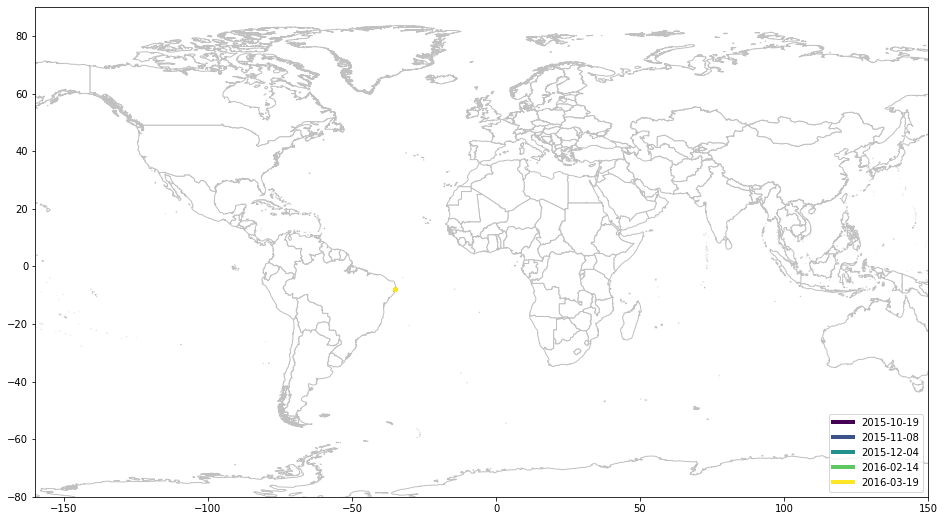

In [14]:
draw_map(df, sg.box(-160, -80, 150, 90))

<AxesSubplot:xlabel='activity'>

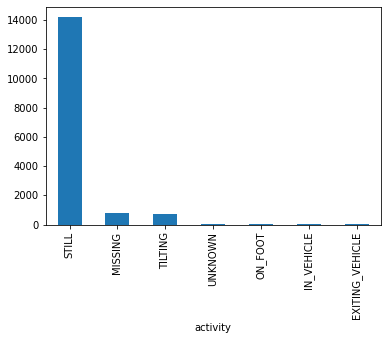

In [15]:
df.groupby(by=df.activity).agg('count').geometry.sort_values(ascending=False).plot.bar()

## Plotando a frequência de atividade

In [16]:
def dt_to_date(dt):
    return dt.date()

def dt_to_first_day_of_month(dt):
    return dt_to_date(dt).replace(day=1)

def aggregate_by(df, fun):
    """
    agg(): Agrega dados usando uma ou mais operações no eixo especificado
    groupby(): Agrupa valores do DataFrame usando um mapeador ou por uma série de colunas
    """
        tuples = [(activity, df[df.activity == activity].groupby(df.timestamp.apply(fun)).activity.agg('count')) 
              for activity 
              in df.activity.drop_duplicates()]
        return pd.DataFrame(dict(tuples))

In [17]:
by_month = aggregate_by(df, dt_to_first_day_of_month)

<AxesSubplot:xlabel='timestamp'>

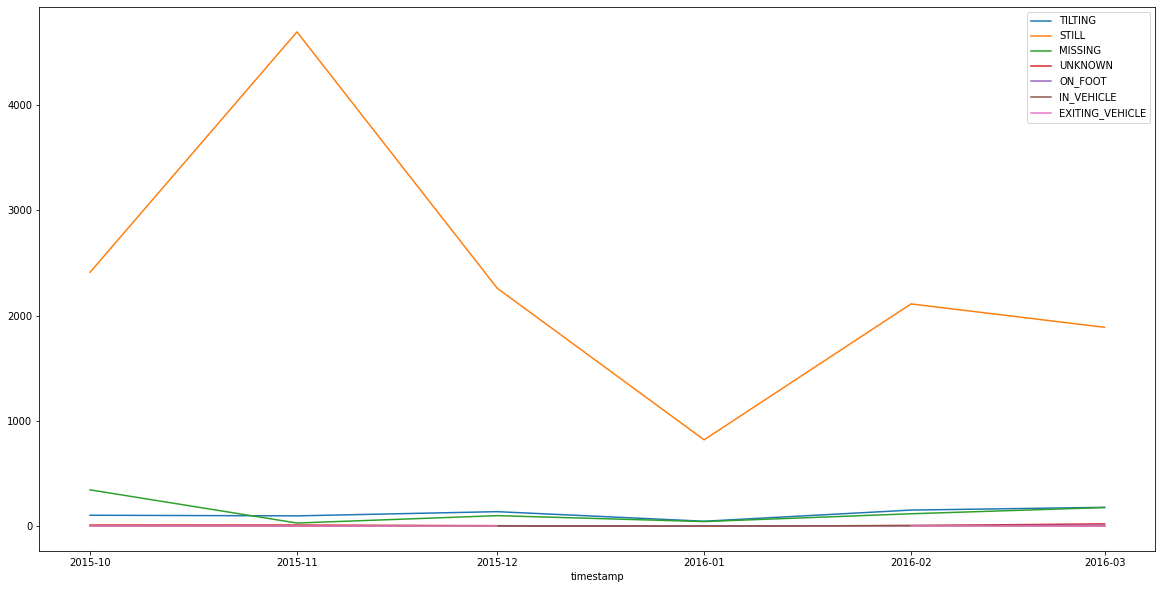

In [18]:
by_month.plot(figsize=[20,10])

In [19]:
by_day = aggregate_by(df, dt_to_date)

<AxesSubplot:xlabel='timestamp'>

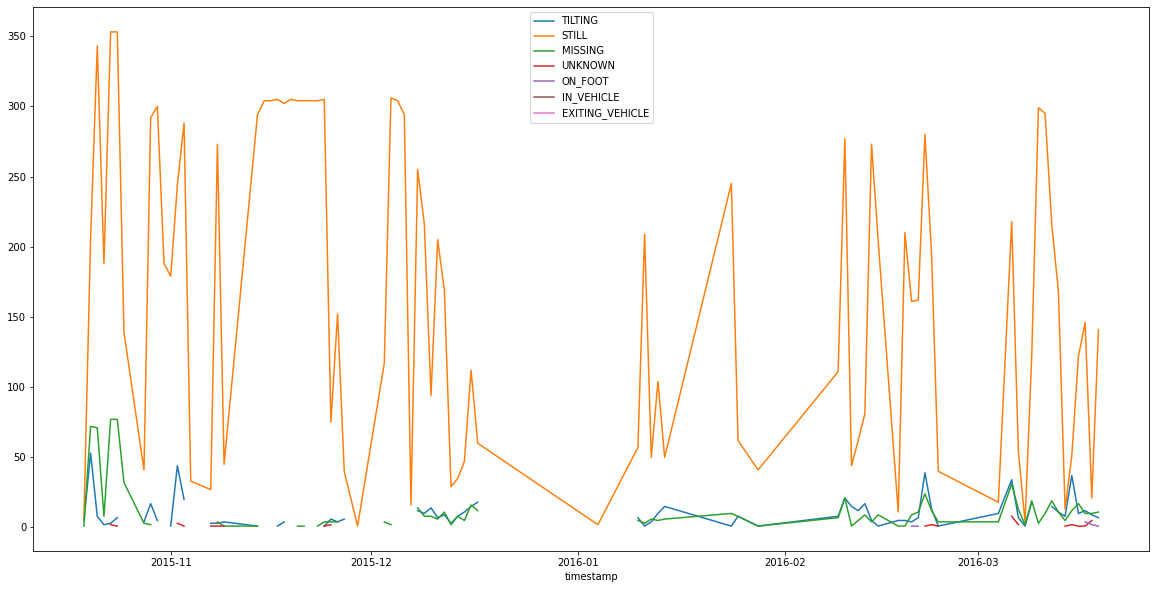

In [20]:
by_day.plot(figsize=[20,10])

<AxesSubplot:xlabel='timestamp'>

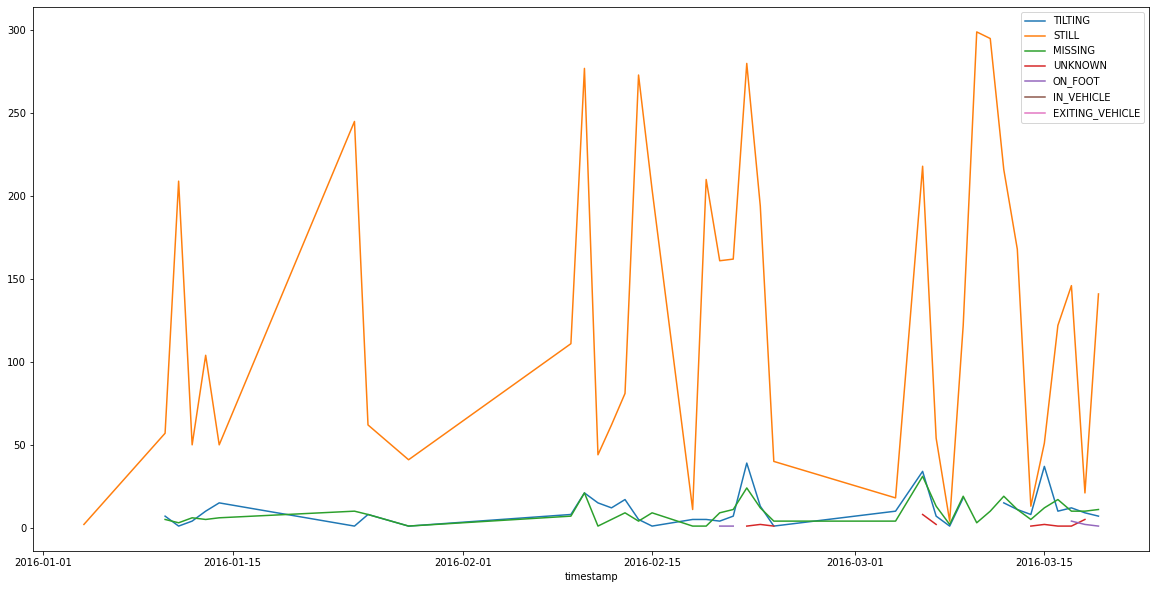

In [21]:
# Selecionando uma faixa temporal específica no gráfico para visualizar
by_day[(by_day.index >= dt.date(2016, 1, 1)) & (by_day.index < dt.date(2017, 1, 1))].plot(figsize=[20,10])

<AxesSubplot:xlabel='timestamp'>

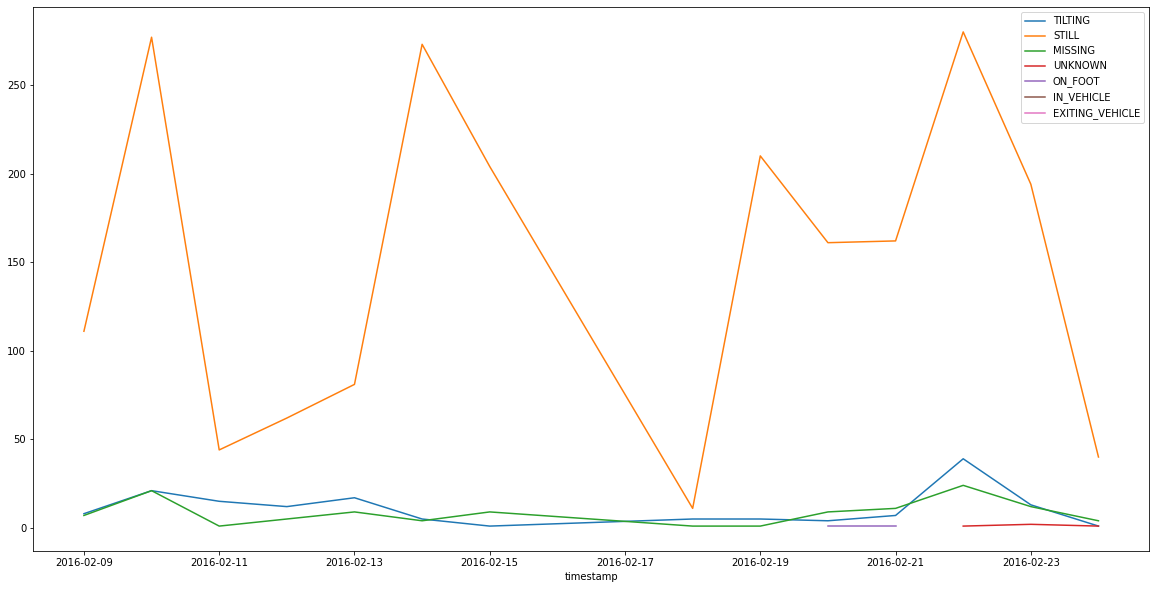

In [22]:
# Reduzindo o intervalo para observar mais detalhes
by_day[(by_day.index >= dt.date(2016, 2, 5)) & (by_day.index < dt.date(2016, 2, 25))].plot(figsize=[20,10])

In [23]:
busy_day = df[df.timestamp.apply(dt_to_date) == dt.date(2016, 2, 22)]

<AxesSubplot:xlabel='timestamp'>

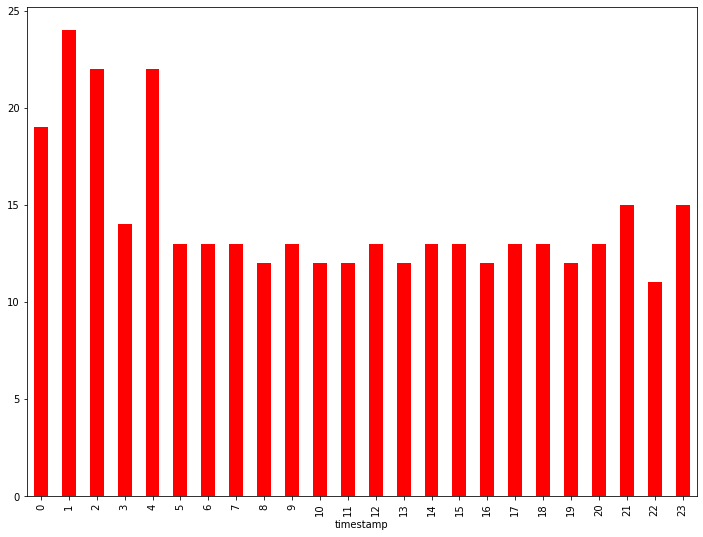

In [28]:
busy_day.groupby(busy_day.timestamp.dt.hour).agg('count').geometry.plot.bar(figsize=[12, 9], color='red')

## Calculando a distância de casa para o trabalho

Trabalhei mais de 6 anos na mesma empresa, mas morei em locais diferentes neste período.     
Por quantos km eu tinha que me deslocar em cada endereço onde morei? 

In [25]:
from geopy.distance import geodesic

In [26]:
mom_house = (-8.1043450, -35.0155787)
my_house = (-8.0591237, -34.8915475)
my_house2 = (-8.2236020, -34.9303107)
job = (-8.0859613, -34.8946645)

print(f"Distância da casa da minha mãe para o trabalho: {round(geodesic(mom_house, job).km, 1)} km")
print(f"Distância da minha casa para o trabalho: {round(geodesic(my_house, job).km, 1)} km")
print(f"Distância do endereço mais recente para o trabalho: {round(geodesic(my_house2, job).km, 1)} km")

Distância da casa da minha mãe para o trabalho: 13.5 km
Distância da minha casa para o trabalho: 3.0 km
Distância do endereço mais recente para o trabalho: 15.7 km


## Referências:
https://nurkiewicz.com/2020/03/see-how-google-is-tracking-your.html

https://pandas.pydata.org/pandas-docs/stable/index.html

# End